# Lung Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import scipy
from scipy import stats
import statsmodels.stats.multitest as ssm

In [2]:
# settings for editable pdfs
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
# # set size of tick labels
# plt.rc('xtick', labelsize=15)
# plt.rc('ytick', labelsize=15)

## Load data, preprocessing

### Load MAF data

In [4]:
# load genie version 8.1
master_mut = pd.read_csv("R_script/cleaned_data/GENIE8.1_master_list_clinical_gen.tsv", sep='\t')

/Users/jamie/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (35,36,53) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Load panels

In [5]:
DFCI_1 = pd.read_csv('R_script/Panels/DFCI_1.txt', sep='\t')
DFCI_2 = pd.read_csv('R_script/Panels/DFCI_2.txt', sep='\t')
DFCI_3 = pd.read_csv('R_script/Panels/DFCI_3.txt', sep='\t')
DFCI_3_1 = DFCI_3.copy()

In [6]:
DFCI_1['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-1'
DFCI_2['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-2'
DFCI_3['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-3'
DFCI_3_1['SEQ_ASSAY_ID'] = 'DFCI-ONCOPANEL-3.1'

In [7]:
MSK_341 = pd.read_csv('R_script/Panels/IMPACT_341.txt', sep='\t')
MSK_410 = pd.read_csv('R_script/Panels/IMPACT_410.txt', sep='\t')
MSK_468 = pd.read_csv('R_script/Panels/IMPACT_468.txt', sep='\t')

In [8]:
MSK_341['SEQ_ASSAY_ID'] = 'MSK-IMPACT-341'
MSK_410['SEQ_ASSAY_ID'] = 'MSK-IMPACT-410'
MSK_468['SEQ_ASSAY_ID'] = 'MSK-IMPACT-468'

In [9]:
combined_panels = pd.concat([DFCI_1, DFCI_2, DFCI_3, DFCI_3_1, MSK_341, MSK_410, MSK_468]).groupby(
    'Hugo_Symbol')['SEQ_ASSAY_ID'].apply(list).to_frame()

### Define Variables of interest

In [10]:
cancers = ['NSCLC', 'LUAD', 'LUSC']

centers = ['MSK', 'DFCI']

panels = ['DFCI-ONCOPANEL-1', 'DFCI-ONCOPANEL-2', 'DFCI-ONCOPANEL-3', 'DFCI-ONCOPANEL-3.1', 
                        'MSK-IMPACT-341', 'MSK-IMPACT-410', 'MSK-IMPACT-468']

races = ['Asian', 'Black', 'White']

sample_types = ['Primary', 'Metastasis']

variants = ['Missense_Mutation', 'Splice_Site', 'Nonsense_Mutation', 'Frame_Shift_Del', 
                         'Frame_Shift_Ins', 'Nonstop_Mutation', 'In_Frame_Del']

### Filter MAF data by variables of interest

In [11]:
master_mut['SEQ_ASSAY_ID'] = master_mut['SEQ_ASSAY_ID'].replace({'MSK-IMPACT341':'MSK-IMPACT-341', 
                                                                 'MSK-IMPACT410':'MSK-IMPACT-410', 
                                                                 'MSK-IMPACT468':'MSK-IMPACT-468'})

In [12]:
# (NOTE From Scanner's code: do not subset by Variant_Classification yet as that will skew our denominator and demographic numbers)

filt_mut = master_mut[(master_mut['ONCOTREE_CODE'].isin(cancers)) & (master_mut['SEQ_ASSAY_ID'].isin(panels)) & (
    master_mut['PRIMARY_RACE'].isin(races) & master_mut['SAMPLE_TYPE'].isin(sample_types))]

## Create dictionaries separated by primary/metstasis

### Non-filtered by variants

In [13]:
mut_dict = {}

In [14]:
mut_dict['prim'] = filt_mut[filt_mut['SAMPLE_TYPE'] == 'Primary']
mut_dict['met'] = filt_mut[filt_mut['SAMPLE_TYPE'] == 'Metastasis']

### Filter by variants of interest

In [15]:
# using this data for subsequent analysis

In [16]:
var_mut_dict = {}

In [17]:
# variants to include
variants = ['Missense_Mutation', 'Splice_Site', 'Nonsense_Mutation', 'Frame_Shift_Del', 
                         'Frame_Shift_Ins', 'Nonstop_Mutation', 'In_Frame_Del']

In [18]:
var_filt_mut = filt_mut[filt_mut['Variant_Classification'].isin(variants)]

In [19]:
var_mut_dict['prim'] =  var_filt_mut[var_filt_mut['SAMPLE_TYPE'] == 'Primary']
var_mut_dict['met'] = var_filt_mut[var_filt_mut['SAMPLE_TYPE'] == 'Metastasis']

## Demographic Information

In [20]:
# looking at non-filtered by variant data

In [21]:
race_demo_dict = {}
panel_demo_dict = {}

### Overall (Primary + Metastasis)

In [22]:
# total number of unique patients
len(filt_mut.groupby('PATIENT_ID').nunique())

6578

In [23]:
race_demo_dict['overall'] = filt_mut.groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
panel_demo_dict['overall'] = filt_mut.groupby('SEQ_ASSAY_ID')['PATIENT_ID'].nunique()

In [24]:
# by race
race_demo_dict['overall']

PRIMARY_RACE
Asian     516
Black     301
White    5761
Name: PATIENT_ID, dtype: int64

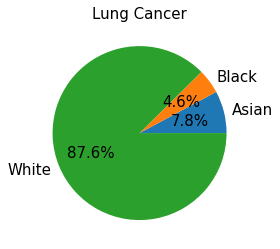

In [25]:
plt.title('Lung Cancer', size=15)
plt.pie(race_demo_dict['overall'], 
        labels=['Asian', 'Black', 'White'],
       autopct='%1.1f%%',
       textprops = dict(rotation_mode = 'anchor', 
#                         va='center', 
#                         ha='center', 
                        size=15));

In [26]:
# by panels
panel_demo_dict['overall']

SEQ_ASSAY_ID
DFCI-ONCOPANEL-1       435
DFCI-ONCOPANEL-2      1097
DFCI-ONCOPANEL-3       725
DFCI-ONCOPANEL-3.1     313
MSK-IMPACT-341         321
MSK-IMPACT-410        1217
MSK-IMPACT-468        2741
Name: PATIENT_ID, dtype: int64

### Primary

In [27]:
# total primary
len(mut_dict['prim'].groupby('PATIENT_ID').nunique())

4219

In [28]:
race_demo_dict['prim'] = mut_dict['prim'].groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
panel_demo_dict['prim'] = mut_dict['prim'].groupby('SEQ_ASSAY_ID')['PATIENT_ID'].nunique()

In [29]:
# by race
race_demo_dict['prim']

PRIMARY_RACE
Asian     321
Black     180
White    3718
Name: PATIENT_ID, dtype: int64

In [30]:
# by panel
panel_demo_dict['prim']

SEQ_ASSAY_ID
DFCI-ONCOPANEL-1       253
DFCI-ONCOPANEL-2       678
DFCI-ONCOPANEL-3       448
DFCI-ONCOPANEL-3.1     160
MSK-IMPACT-341         199
MSK-IMPACT-410         746
MSK-IMPACT-468        1794
Name: PATIENT_ID, dtype: int64

### Metastasis

In [31]:
# total metastasis
len(mut_dict['met'].groupby('PATIENT_ID').nunique())

2625

In [32]:
race_demo_dict['met'] = mut_dict['met'].groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
panel_demo_dict['met'] = mut_dict['met'].groupby('SEQ_ASSAY_ID')['PATIENT_ID'].nunique()

In [33]:
# by race
race_demo_dict['met']

PRIMARY_RACE
Asian     236
Black     136
White    2253
Name: PATIENT_ID, dtype: int64

In [34]:
# by panel
panel_demo_dict['met']

SEQ_ASSAY_ID
DFCI-ONCOPANEL-1       182
DFCI-ONCOPANEL-2       432
DFCI-ONCOPANEL-3       281
DFCI-ONCOPANEL-3.1     156
MSK-IMPACT-341         124
MSK-IMPACT-410         497
MSK-IMPACT-468        1049
Name: PATIENT_ID, dtype: int64

## Calculate mutation frequency (for all genes)

In [35]:
# remove patients with duplicate tumors sequenced by multiple panels
# choose sample sequenced by larger panel

# mut_tbl: mutation table in MAF format
def remove_duplicates(mut_tbl):
    # group by patient and panel to find the unique sample IDs
    df = mut_tbl.groupby(['PATIENT_ID', 'SEQ_ASSAY_ID'])['SAMPLE_ID'].unique().to_frame()
    # choose the last panel for each patient
    samples = np.concatenate(df.groupby('PATIENT_ID').tail(1)['SAMPLE_ID'])
    # filter out the duplicates
    cleaned_mut = mut_tbl[mut_tbl['SAMPLE_ID'].isin(samples)]
    
    return cleaned_mut

In [36]:
# count patients sequenced by each panel by race

# mut_tbl: mutation table in MAF format
# combined_panels: table with genes as rows, lists of panels that sequenced that gene as column
# race_category: name of race column
def calc_seq_counts(mut_tbl, combined_panels, race_category):
    # first remove duplicates to get accurate sequenced count
    mut_tbl = remove_duplicates(mut_tbl)
    
    # count number of patients for each panel
    panel_race_counts = mut_tbl.groupby(['SEQ_ASSAY_ID', race_category])[
        'PATIENT_ID'].nunique().reset_index().pivot_table(index='SEQ_ASSAY_ID', columns=race_category, 
                                                          values='PATIENT_ID', fill_value=0)
    # count number of patients by race sequenced for one gene
    def sum_gene_counts(row):
        count = np.sum(panel_race_counts[panel_race_counts.index.isin(row)], axis=0)
        return count
    
    # apply function to all genes
    seq_cnt = combined_panels['SEQ_ASSAY_ID'].apply(sum_gene_counts)
    
    return seq_cnt
#     return panel_race_counts

In [37]:
# calculate mutation frequency

# mut_tbl: MAF mutation table
# var_mut_tbl: mut_tbl filtered by variants we excluded
# combined_panels: table with genes as rows, lists of panels that sequenced that gene as column
# race_category: name of race column
def calc_mut_freq(mut_tbl, var_mut_tbl, combined_panels, race_category):
    
    # calculate number of patients sequenced in each race category for all genes in panels
    seq_cnt = calc_seq_counts(mut_tbl, combined_panels, race_category)
    
    # remove duplicates before counting mutations
    var_mut_tbl = remove_duplicates(var_mut_tbl)
    
    # calculate number of patients w/ mutation in each race category for each gene in MAF table
    mut_cnt = var_mut_tbl.groupby(['Hugo_Symbol', race_category])['PATIENT_ID'].nunique().reset_index().pivot_table(
        index='Hugo_Symbol', columns=race_category, values='PATIENT_ID', fill_value=0)
    
    mut_seq = mut_cnt.join(seq_cnt, how='outer', lsuffix='_mut', rsuffix='_seq')
    
    # find any missing genes that weren't included in panel but still had mutations
    # don't know why these are included in the panel in GENIE but not elsewhere
    # total for DFCI is especially wrong (looking directly at the genomic_information.txt file)
    missing = mut_seq[mut_seq['Asian_seq'].isna()]
    
    # remove missing genes
    mut_seq = mut_seq[~mut_seq.index.isin(missing.index)]
    
#     # fill NaN mutation values with zero
#     mut_seq = mut_seq.fillna(0)

    # remove NaN mutation values (genes that were sequenced but have no mutation counts)
    mut_seq = mut_seq.dropna()
    
    # compute mutation frequency
    mut_columns = mut_seq.columns[mut_seq.columns.str.contains('_mut')]
    seq_columns = mut_seq.columns[mut_seq.columns.str.contains('_seq')]
    
    mut_freq = mut_seq[mut_columns] / mut_seq[seq_columns].values * 100
    mut_freq.columns = mut_freq.columns.str.replace('_mut', '')
    
    return mut_seq, mut_freq
    

In [38]:
mut_freq_dict = {}
mut_seq_dict = {}

In [39]:
for (k1, v1), (k2, v2) in zip(mut_dict.items(), var_mut_dict.items()):
    mut_seq_dict[k1], mut_freq_dict[k1] = calc_mut_freq(v1, v2, combined_panels, 'PRIMARY_RACE')

## Significance testing functions

### Fisher's Test and FDR

In [40]:
# performs Fisher's exact test for one gene between two races and calculates 95% confidence interval

# row: gene row
# group1: name of first race
# group2: name of second race
def fisher_one_gene(row, group1, group2):
    seq_group1 = row[group1 + '_seq']
    seq_group2 = row[group2 + '_seq']
    
    mut_group1 = row[group1 + '_mut']
    mut_group2 = row[group2 + '_mut']
    
    a = mut_group1
    b = mut_group2
    c = seq_group1 - a
    d = seq_group2 - b
    
    cont_tbl = pd.DataFrame(np.array([[a, c],
                                     [b, d]]), index=[group1, group2], columns=['Mutation', 'No Mutation'])
    
    odds_ratio, p_val = scipy.stats.fisher_exact(cont_tbl)
    
    # calculate 95% confidence interval    
    SE = np.sqrt(1/a + 1/c + 1/b + 1/d) 
    
    c1 = round(odds_ratio * np.exp(-1.96 * SE), 3)
    c2 = round(odds_ratio * np.exp(1.96 * SE), 3)
    
    CI = (c1, c2)
    
    return cont_tbl, odds_ratio, p_val, CI

In [41]:
# performs Fisher's exact test for all genes between two races and computes FDR

# mut_tbl: table with genes as rows and *_mut/*_seq counts as columns (* is name of race group)
# group1: name of first race
# group2: name of second race

def fisher_all_genes(mut_tbl, group1, group2):
    fisher = mut_tbl.apply(lambda x: fisher_one_gene(x, group1, group2), axis=1)
    
    fisher_tbl = pd.DataFrame(fisher.to_list(), index=fisher.index).iloc[:,1:].rename(
        columns={1:group1 + '_' + group2 + '_odds_ratio', 
                 2:group1 + '_' + group2 + '_pval', 
                 3:group1 + '_' + group2 + '_CI'})
    fdr = ssm.multipletests(fisher_tbl[group1 + '_' + group2 + '_pval'], method='fdr_bh')[1]
    fisher_tbl.insert(2, group1 + '_' + group2 + '_fdr', fdr)
    
    return fisher_tbl

In [42]:
# performs Fisher's exact test for all race comparisons, and computes FDR

# mut_tbl: table with genes as rows and *_mut/*_seq counts as columns (* is name of race group)
# groups: list of tuples with race comparisons
def fisher_fdr_all_groups(mut_tbl, groups):
    fisher_tbl = pd.DataFrame()
    for group in groups:
        fisher_tbl = pd.concat([fisher_tbl, fisher_all_genes(mut_tbl, group[0], group[1])], axis=1)

    return fisher_tbl

In [43]:
# change if doing different comparisons
groups = [('Black', 'White'), 
          ('Black', 'Asian'), 
          ('Asian', 'White')]

### Significant genes

In [44]:
# finds significant genes based on FDR cutoff specified

# pvals: table of p-values, genes as rows, race comparisons as columns
# mut_freq: table of mutation frequencies, genes as rows, races as columns
# fdr_cutoff: float
def find_sig_genes(pvals, mut_freq, fdr_cutoff):
    cols = pvals.columns[pvals.columns.str.contains('fdr')]
    pval_cols = pvals[cols]    
    
    sig_pval = pval_cols[(pval_cols <= fdr_cutoff).any(1)]
    sig_genes = sig_pval.index
    sig_pval = pvals.loc[sig_genes]
    
    sig_pct = mut_freq.loc[sig_genes]
    
    return sig_genes.to_list(), sig_pval, sig_pct

In [45]:
# finds significant genes for all groups

# race_pairs: list of tuples with race comparisons
# pvals: table of p-values, genes as rows, race comparisons as columns
# mut_freq: table of mutation frequencies, genes as rows, races as columns
# fdr_cutoff: float
def find_sig_genes_groups(race_pairs, pvals, mut_freq, fdr_cutoff):
    sig_pval_dict = {}
    sig_freq_dict = {}
    sig_gene_list = []
    for pair in race_pairs:
        pair_cols = ['_'.join(pair) + '_pval', '_'.join(pair) + '_fdr', 
                     '_'.join(pair) + '_odds_ratio', '_'.join(pair) + '_CI']
        pair_pval = pvals[pair_cols]
        pair_mut_freq = mut_freq[[pair[0], pair[1]]]
        sig_genes, sig_pval_dict[pair], sig_freq_dict[pair] = find_sig_genes(pair_pval, pair_mut_freq, fdr_cutoff)
        sig_gene_list = sig_gene_list + sig_genes
    
    # remove duplicates
    sig_gene_list = set(sig_gene_list)
    
    return sig_gene_list, sig_pval_dict, sig_freq_dict

## Composition plot functions

### Variant Composition Plots

In [46]:
# calculate variant composition for genes of interest

# mut_tbl: MAF table
# genes: list of genes of interest
def variant_comp(mut_tbl, genes):
    # filter mut_tbl by genes of interest
    filt_mut = mut_tbl[mut_tbl['Hugo_Symbol'].isin(genes)]
    comp_mut = filt_mut.groupby(['Hugo_Symbol', 'Variant_Classification'])['PATIENT_ID'].nunique().reset_index().pivot_table(
        index='Hugo_Symbol', columns='Variant_Classification', values='PATIENT_ID', fill_value=0)
    pct_mut = comp_mut.div(comp_mut.sum(axis=1), axis=0) * 100
    
    return comp_mut, pct_mut

### Panel Composition Plots

In [47]:
# calculate panel composition for genes of interest

# mut_tbl: MAF table
# genes: list of genes of interest
def panel_comp(mut_tbl, genes):
    # filter mut_tbl by genes of interest
    filt_mut = mut_tbl[mut_tbl['Hugo_Symbol'].isin(genes)]
    comp_mut = filt_mut.groupby(['Hugo_Symbol', 'SEQ_ASSAY_ID'])['PATIENT_ID'].nunique().reset_index().pivot_table(
        index='Hugo_Symbol', columns='SEQ_ASSAY_ID', values='PATIENT_ID', fill_value=0)
    pct_mut = comp_mut.div(comp_mut.sum(axis=1), axis=0) * 100
    
    return comp_mut, pct_mut

## Top Mutations

### Find genes most frequently altered overall and by race

In [48]:
# calculate mutations most common in all patients, count number of patients with that mutation

# mut_tbl: MAF table
def common_mut_overall(mut_tbl):
    common_mut = mut_tbl.groupby('Hugo_Symbol')['PATIENT_ID'].nunique().sort_values(ascending=False)
    
    return common_mut

In [49]:
# most common mutations for each race

# mut_tbl: MAF table
# race_category: race column name
# races: list of races of interest
def common_mut_race(mut_tbl, race_category, races):    
    common_dict = {}
    
    for race in races:
        race_tbl = mut_tbl[mut_tbl[race_category] == race]
        common_tbl = common_mut_overall(race_tbl)
        common_dict[race] = common_tbl
        
    return common_dict

In [50]:
common_mut_dict = {}

In [51]:
for key, value in var_mut_dict.items():
    common_mut_dict[key] = common_mut_overall(value)

In [52]:
common_mut_race_dict = {}

In [53]:
for key, value in var_mut_dict.items():
    common_mut_race_dict[key] = common_mut_race(value, 'PRIMARY_RACE', ['Asian', 'Black', 'White'])   

### Top 20 mutations overall

In [54]:
# top 20 primary
common_mut_dict['prim'].head(20)

Hugo_Symbol
TP53       2080
KRAS       1414
EGFR        925
STK11       625
KEAP1       551
KMT2D       418
RBM10       394
ATM         375
NF1         369
PTPRD       333
CDKN2A      307
FAT1        301
ARID1A      293
PIK3CA      292
SMARCA4     288
SETD2       278
ATRX        261
NTRK3       253
EPHA3       248
BRAF        233
Name: PATIENT_ID, dtype: int64

In [55]:
# top 20 metastatic
common_mut_dict['met'].head(20)

Hugo_Symbol
TP53       1600
KRAS        755
EGFR        666
KEAP1       423
STK11       374
SMARCA4     285
KMT2D       270
ATM         269
NF1         239
ARID1A      236
PTPRD       231
FAT1        200
CDKN2A      199
RBM10       190
SETD2       189
EPHA5       180
APC         177
RB1         163
ALK         159
PIK3CA      158
Name: PATIENT_ID, dtype: int64

In [56]:
top_mut_seq_dict = {}
top_mut_freq_dict = {}

In [57]:
for key, value in common_mut_dict.items():
    top_20 = value.head(20).index
    top_mut_seq_dict[key] = mut_seq_dict[key].loc[top_20]
    top_mut_freq_dict[key] = mut_freq_dict[key].loc[top_20]

## TumorPortal genes

### Subset mutation data by tumor portal genes

In [58]:
# load tumor portal genes
genes = pd.read_csv('R_script/cleaned_data/sig_mut_genes_lung.txt', sep='\t')

In [59]:
# remove TumorPortal genes that are not in data
prim_genes = genes[genes['Hugo_Symbol'].isin(mut_seq_dict['prim'].index)]  
met_genes = genes[genes['Hugo_Symbol'].isin(mut_seq_dict['met'].index)]

In [60]:
# check genes are same among prim and met data
# if numbers are different, need to change downstream analysis
print(len(genes), len(prim_genes), len(met_genes))

27 23 23


In [61]:
prim_genes == met_genes

,Hugo_Symbol
0,True
1,True
2,True
3,True
4,True
5,True
6,True
7,True
8,True
9,True


In [62]:
# from here assuming that Tumor Portal genes are the same in prim and met datasets
# both prim and met have the same tumor portal genes of interest
# if not all True in printouts above, need to modify code

In [63]:
tp_mut_seq_dict = {}
tp_mut_freq_dict = {}

In [64]:
for (k1, v1), (k2, v2) in zip(mut_seq_dict.items(), mut_freq_dict.items()):
    tp_mut_seq_dict[k1] = v1.loc[prim_genes.iloc[:,0]]
    tp_mut_freq_dict[k1] = v2.loc[prim_genes.iloc[:,0]]

## Top 20 + Tumor Portal Combined

### Combine Top 20 + TP data together

In [65]:
# use these for prevalence bar charts
comb_mut_seq_dict = {}
comb_mut_freq_dict = {}

In [66]:
for (k1, v1), (k2, v2) in zip(top_mut_seq_dict.items(), tp_mut_seq_dict.items()):
    comb_mut_seq_dict[k1] = pd.concat([v1, v2]).drop_duplicates()

In [67]:
for (k1, v1), (k2, v2) in zip(top_mut_freq_dict.items(), tp_mut_freq_dict.items()):
    comb_mut_freq_dict[k1] = pd.concat([v1, v2]).drop_duplicates()

### Fisher's Test and FDR

In [68]:
# outer join Top 20 primary and metastatic genes together for FDR calculation
# so we can compare genes from both in FDR scatter plots

In [69]:
# for visualization, these are the genes from Top 20 primary not in Top 20 metastasis
comb_mut_seq_dict['prim'][~comb_mut_seq_dict['prim'].index.isin(comb_mut_seq_dict['met'].index)].index

Index(['ATRX', 'NTRK3', 'EPHA3'], dtype='object', name='Hugo_Symbol')

In [70]:
comb_mut_seq_dict['met'][~comb_mut_seq_dict['met'].index.isin(comb_mut_seq_dict['prim'].index)].index

Index(['EPHA5', 'APC', 'ALK'], dtype='object', name='Hugo_Symbol')

In [71]:
comb_genes = comb_mut_seq_dict['prim'].index | comb_mut_seq_dict['met'].index

In [72]:
comb_pm_mut_seq_dict = {}
comb_pm_mut_freq_dict = {}

In [73]:
for (k1, v1), (k2, v2) in zip(mut_seq_dict.items(), mut_freq_dict.items()):
    comb_pm_mut_seq_dict[k1] = v1.loc[comb_genes]
    comb_pm_mut_freq_dict[k1] = v2.loc[comb_genes]

In [74]:
comb_pval_dict = {}

In [75]:
for key, value in comb_pm_mut_seq_dict.items():
    comb_pval_dict[key] = fisher_fdr_all_groups(value, groups)

<ipython-input-40-ce1fee6a180c>:24: RuntimeWarning: divide by zero encountered in double_scalars
  SE = np.sqrt(1/a + 1/c + 1/b + 1/d)
<ipython-input-40-ce1fee6a180c>:27: RuntimeWarning: invalid value encountered in double_scalars
  c2 = round(odds_ratio * np.exp(1.96 * SE), 3)
<ipython-input-40-ce1fee6a180c>:26: RuntimeWarning: invalid value encountered in double_scalars
  c1 = round(odds_ratio * np.exp(-1.96 * SE), 3)


### Significant genes

In [76]:
comb_sig_pval_dict = {}
comb_sig_freq_dict = {}
comb_sig_genes_dict = {}

In [77]:
for (k1, v1), (k2, v2) in zip(comb_pval_dict.items(), comb_pm_mut_freq_dict.items()):
    comb_sig_genes_dict[k1], comb_sig_pval_dict[k1], comb_sig_freq_dict[k1] = find_sig_genes_groups(
        groups, v1, v2, 0.05)

#### Primary

In [78]:
comb_sig_pval_dict['prim']

{('Black',
  'White'):              Black_White_pval  Black_White_fdr  Black_White_odds_ratio  \
 Hugo_Symbol                                                              
 EGFR                 0.000211         0.006949                1.907088   
 
              Black_White_CI  
 Hugo_Symbol                  
 EGFR         (1.374, 2.647)  ,
 ('Black',
  'Asian'):              Black_Asian_pval  Black_Asian_fdr  Black_Asian_odds_ratio  \
 Hugo_Symbol                                                              
 EGFR                 0.000002         0.000053                0.390824   
 KEAP1                0.008120         0.038281                2.529027   
 KRAS                 0.000113         0.001242                2.555234   
 NF1                  0.000262         0.002158                3.644970   
 NFE2L2               0.001557         0.010278               14.883721   
 PTPRD                0.000046         0.000758                4.089151   
 TP53                 0.003840     

In [79]:
comb_sig_freq_dict['prim']

{('Black',
  'White'): PRIMARY_RACE      Black      White
 Hugo_Symbol                       
 EGFR          30.555556  18.746638,
 ('Black',
  'Asian'): PRIMARY_RACE      Black      Asian
 Hugo_Symbol                       
 EGFR          30.555556  52.959502
 KEAP1         12.571429   5.379747
 KRAS          26.111111  12.149533
 NF1           13.333333   4.049844
 NFE2L2         4.444444   0.311526
 PTPRD         16.875000   4.729730
 TP53          58.333333  44.548287,
 ('Asian',
  'White'): PRIMARY_RACE      Asian      White
 Hugo_Symbol                       
 ATM            4.049844   9.332975
 ATRX           2.492212   6.481980
 CDKN2A         3.738318   7.557827
 EGFR          52.959502  18.746638
 FAT1           3.780069   9.643606
 KEAP1          5.379747  14.721104
 KMT2D          4.430380  11.098332
 KRAS          12.149533  35.664336
 NF1            4.049844   8.848843
 NFE2L2         0.311526   3.684777
 PTPRD          4.729730   9.958791
 SMARCA4        2.180685   7.261

In [80]:
comb_mut_freq_dict['prim'].loc[comb_sig_genes_dict['prim']]

PRIMARY_RACE,Asian,Black,White
Hugo_Symbol,,,
PTPRD,4.729730,16.875000,9.958791
CDKN2A,3.738318,7.222222,7.557827
KRAS,12.149533,26.111111,35.664336
ATM,4.049844,6.666667,9.332975
EGFR,52.959502,30.555556,18.746638
SMARCA4,2.180685,5.555556,7.261969
KEAP1,5.379747,12.571429,14.721104
KMT2D,4.430380,9.714286,11.098332
TP53,44.548287,58.333333,49.166218


In [81]:
comb_pval_dict['prim'].loc[comb_sig_genes_dict['prim']]

,Black_White_odds_ratio,Black_White_pval,Black_White_fdr,Black_White_CI,Black_Asian_odds_ratio,Black_Asian_pval,Black_Asian_fdr,Black_Asian_CI,Asian_White_odds_ratio,Asian_White_pval,Asian_White_fdr,Asian_White_CI
Hugo_Symbol,,,,,,,,,,,,
PTPRD,1.835468,0.010411,0.114524,"(1.193, 2.825)",4.089151,0.000046,0.000758,"(2.077, 8.052)",0.448863,2.369402e-03,6.515855e-03,"(0.259, 0.778)"
CDKN2A,0.952138,1.000000,1.000000,"(0.535, 1.696)",2.004491,0.091470,0.182758,"(0.894, 4.492)",0.475003,9.497207e-03,2.410830e-02,"(0.263, 0.856)"
KRAS,0.637476,0.008340,0.114524,"(0.454, 0.895)",2.555234,0.000113,0.001242,"(1.594, 4.096)",0.249479,4.607974e-20,7.603157e-19,"(0.177, 0.351)"
ATM,0.693907,0.289656,0.822802,"(0.382, 1.259)",1.692308,0.205425,0.322811,"(0.755, 3.792)",0.410036,7.020723e-04,2.574265e-03,"(0.233, 0.722)"
EGFR,1.907088,0.000211,0.006949,"(1.374, 2.647)",0.390824,0.000002,0.000053,"(0.266, 0.575)",4.879664,1.166554e-38,3.849628e-37,"(3.861, 6.167)"
SMARCA4,0.751198,0.460958,0.963085,"(0.392, 1.439)",2.638655,0.068621,0.181591,"(0.987, 7.057)",0.284690,1.874836e-04,1.031160e-03,"(0.133, 0.608)"
KEAP1,0.832976,0.510396,0.963085,"(0.528, 1.315)",2.529027,0.008120,0.038281,"(1.304, 4.904)",0.329366,6.429030e-07,5.303950e-06,"(0.2, 0.542)"
KMT2D,0.861874,0.710127,1.000000,"(0.517, 1.437)",2.320976,0.031472,0.115397,"(1.115, 4.831)",0.371341,7.550658e-05,4.983434e-04,"(0.215, 0.641)"
TP53,1.447484,0.017854,0.129621,"(1.069, 1.96)",1.742657,0.003840,0.021121,"(1.205, 2.521)",0.830619,1.163428e-01,1.919657e-01,"(0.66, 1.045)"


#### Asian vs White

In [82]:
comb_sig_pval_dict['prim'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
Hugo_Symbol,,,,
ATM,7.020723e-04,2.574265e-03,0.410036,"(0.233, 0.722)"
ATRX,2.358733e-03,6.515855e-03,0.368751,"(0.181, 0.753)"
CDKN2A,9.497207e-03,2.410830e-02,0.475003,"(0.263, 0.856)"
EGFR,1.166554e-38,3.849628e-37,4.879664,"(3.861, 6.167)"
FAT1,3.801265e-04,1.568022e-03,0.368090,"(0.199, 0.681)"
KEAP1,6.429030e-07,5.303950e-06,0.329366,"(0.2, 0.542)"
KMT2D,7.550658e-05,4.983434e-04,0.371341,"(0.215, 0.641)"
KRAS,4.607974e-20,7.603157e-19,0.249479,"(0.177, 0.351)"
NF1,2.254292e-03,6.515855e-03,0.434779,"(0.247, 0.766)"


In [83]:
comb_sig_freq_dict['prim'][('Asian', 'White')]

PRIMARY_RACE,Asian,White
Hugo_Symbol,,
ATM,4.049844,9.332975
ATRX,2.492212,6.481980
CDKN2A,3.738318,7.557827
EGFR,52.959502,18.746638
FAT1,3.780069,9.643606
KEAP1,5.379747,14.721104
KMT2D,4.430380,11.098332
KRAS,12.149533,35.664336
NF1,4.049844,8.848843


#### Black vs White

In [84]:
comb_sig_pval_dict['prim'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI
Hugo_Symbol,,,,
EGFR,0.000211,0.006949,1.907088,"(1.374, 2.647)"


In [85]:
comb_sig_freq_dict['prim'][('Black', 'White')]

PRIMARY_RACE,Black,White
Hugo_Symbol,,
EGFR,30.555556,18.746638


#### Black vs Asian

In [86]:
comb_sig_pval_dict['prim'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
Hugo_Symbol,,,,
EGFR,0.000002,0.000053,0.390824,"(0.266, 0.575)"
KEAP1,0.008120,0.038281,2.529027,"(1.304, 4.904)"
KRAS,0.000113,0.001242,2.555234,"(1.594, 4.096)"
NF1,0.000262,0.002158,3.644970,"(1.807, 7.354)"
NFE2L2,0.001557,0.010278,14.883721,"(1.846, 119.99)"
PTPRD,0.000046,0.000758,4.089151,"(2.077, 8.052)"
TP53,0.003840,0.021121,1.742657,"(1.205, 2.521)"


In [87]:
comb_sig_freq_dict['prim'][('Black', 'Asian')]

PRIMARY_RACE,Black,Asian
Hugo_Symbol,,
EGFR,30.555556,52.959502
KEAP1,12.571429,5.379747
KRAS,26.111111,12.149533
NF1,13.333333,4.049844
NFE2L2,4.444444,0.311526
PTPRD,16.875000,4.729730
TP53,58.333333,44.548287


#### Metastasis

In [88]:
comb_sig_pval_dict['met']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
 Index: [],
 ('Black',
  'Asian'):              Black_Asian_pval  Black_Asian_fdr  Black_Asian_odds_ratio  \
 Hugo_Symbol                                                              
 CDKN2A           5.899167e-03     3.893450e-02                3.228571   
 EGFR             8.321387e-09     2.746058e-07                0.270893   
 KEAP1            3.372996e-03     2.782722e-02                3.068584   
 KRAS             2.586793e-04     2.845473e-03                2.967075   
 STK11            3.766518e-07     6.214755e-06                9.403540   
 
               Black_Asian_CI  
 Hugo_Symbol                   
 CDKN2A        (1.433, 7.272)  
 EGFR          (0.172, 0.426)  
 KEAP1         (1.439, 6.545)  
 KRAS           (1.658, 5.31)  
 STK11        (3.484, 25.382)  ,
 ('Asian',
  'White'):              Asian_White_pval  Asian_White_fdr  Asian_White_odds_r

In [89]:
comb_sig_freq_dict['met']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black, White]
 Index: [],
 ('Black',
  'Asian'): PRIMARY_RACE      Black      Asian
 Hugo_Symbol                       
 CDKN2A        12.500000   4.237288
 EGFR          28.676471  59.745763
 KEAP1         14.393939   5.194805
 KRAS          24.264706   9.745763
 STK11         16.911765   2.118644,
 ('Asian',
  'White'): PRIMARY_RACE      Asian      White
 Hugo_Symbol                       
 ATM            5.508475  10.696849
 ATRX           2.118644   6.213937
 EGFR          59.745763  21.526853
 EPHA3          1.941748   7.298881
 EPHA5          2.912621   8.737347
 KEAP1          5.194805  18.735026
 KRAS           9.745763  31.025300
 PIK3CA        10.169492   5.725699
 SMARCA4        5.084746  11.318242
 STK11          2.118644  15.312916}

#### Asian vs White

In [90]:
comb_sig_pval_dict['met'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
Hugo_Symbol,,,,
ATM,1.233981e-02,4.072139e-02,0.486687,"(0.274, 0.865)"
ATRX,7.905554e-03,3.261041e-02,0.326685,"(0.133, 0.805)"
EGFR,8.578416e-33,2.830877e-31,5.410483,"(4.094, 7.151)"
EPHA3,1.865606e-03,8.973007e-03,0.251500,"(0.092, 0.687)"
EPHA5,1.903365e-03,8.973007e-03,0.313354,"(0.137, 0.717)"
KEAP1,1.339714e-08,1.105264e-07,0.237676,"(0.132, 0.429)"
KRAS,9.378035e-14,1.547376e-12,0.240061,"(0.155, 0.373)"
PIK3CA,1.009361e-02,3.700990e-02,1.863975,"(1.179, 2.947)"
SMARCA4,1.894294e-03,8.973007e-03,0.419748,"(0.231, 0.761)"


In [91]:
comb_sig_freq_dict['met'][('Asian', 'White')]

PRIMARY_RACE,Asian,White
Hugo_Symbol,,
ATM,5.508475,10.696849
ATRX,2.118644,6.213937
EGFR,59.745763,21.526853
EPHA3,1.941748,7.298881
EPHA5,2.912621,8.737347
KEAP1,5.194805,18.735026
KRAS,9.745763,31.025300
PIK3CA,10.169492,5.725699
SMARCA4,5.084746,11.318242


#### Black vs White

In [92]:
comb_sig_pval_dict['met'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI
Hugo_Symbol,,,,


In [93]:
comb_sig_freq_dict['met'][('Black', 'White')]

PRIMARY_RACE,Black,White
Hugo_Symbol,,


#### Black vs Asian

In [94]:
comb_sig_pval_dict['met'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
Hugo_Symbol,,,,
CDKN2A,5.899167e-03,3.893450e-02,3.228571,"(1.433, 7.272)"
EGFR,8.321387e-09,2.746058e-07,0.270893,"(0.172, 0.426)"
KEAP1,3.372996e-03,2.782722e-02,3.068584,"(1.439, 6.545)"
KRAS,2.586793e-04,2.845473e-03,2.967075,"(1.658, 5.31)"
STK11,3.766518e-07,6.214755e-06,9.403540,"(3.484, 25.382)"


In [95]:
comb_sig_freq_dict['met'][('Black', 'Asian')]

PRIMARY_RACE,Black,Asian
Hugo_Symbol,,
CDKN2A,12.500000,4.237288
EGFR,28.676471,59.745763
KEAP1,14.393939,5.194805
KRAS,24.264706,9.745763
STK11,16.911765,2.118644


### Mutation Prevalence Plots

#### Primary Genes

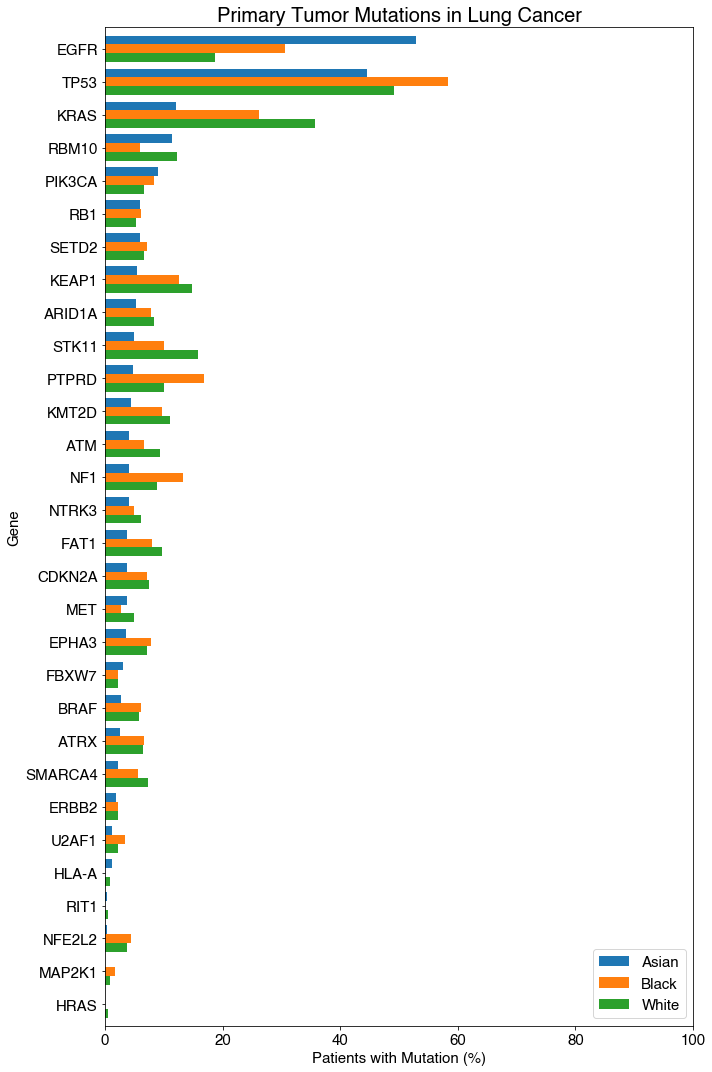

In [96]:
df = comb_mut_freq_dict['prim'].sort_values(['Asian'], ascending=False)
ax = df.plot(kind='barh', figsize=(10, 15), width=0.8)
hfont = {'fontname':'Helvetica'}
plt.title('Primary Tumor Mutations in Lung Cancer', fontsize=20, **hfont)
plt.xlabel('Patients with Mutation (%)', fontsize=15, **hfont)
plt.ylabel('Gene', fontsize=15, **hfont)
plt.xticks(size=15, **hfont)
plt.yticks(size=15, **hfont)
plt.xlim((0, 100))
ax.invert_yaxis()
plt.legend(prop={'family':'Helvetica', 'size': 15}, loc='lower right')
plt.tight_layout()
# plt.savefig('figures/lung/Top20+Tumor_Portal/lung_top20+TP_prim.pdf')

#### Metastatic Genes

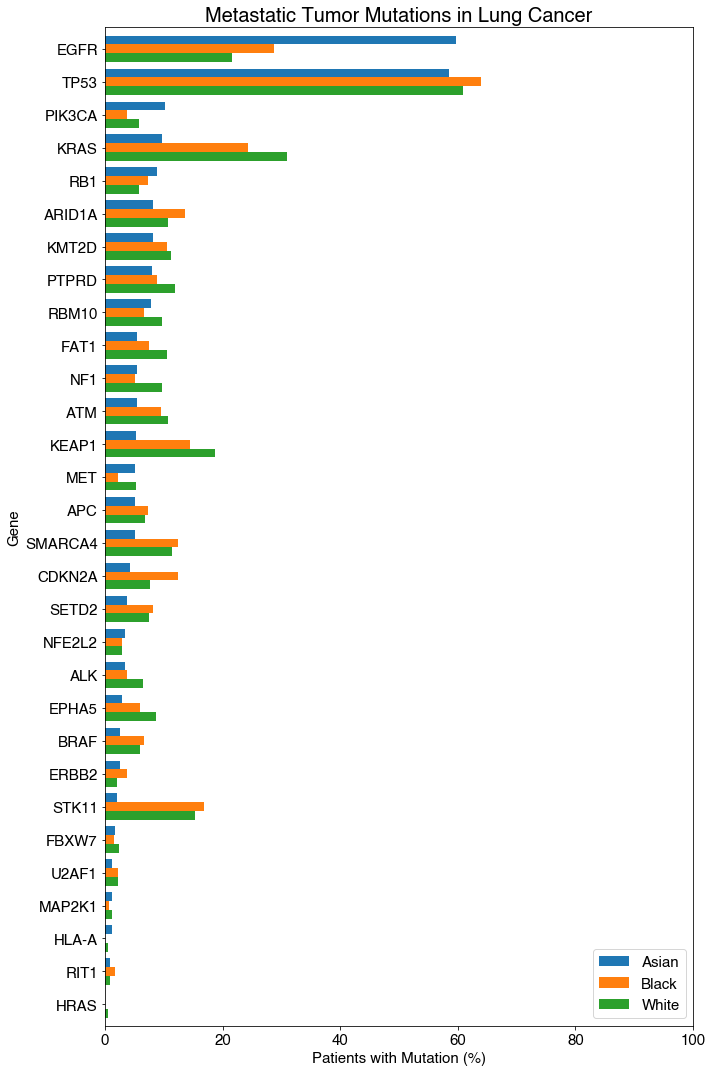

In [97]:
df = comb_mut_freq_dict['met'].sort_values(['Asian'], ascending=False)
ax = df.plot(kind='barh', figsize=(10, 15), width=0.8)
hfont = {'fontname':'Helvetica'}
plt.title('Metastatic Tumor Mutations in Lung Cancer', fontsize=20, **hfont)
plt.xlabel('Patients with Mutation (%)', fontsize=15, **hfont)
plt.ylabel('Gene', fontsize=15, **hfont)
plt.xticks(size=15, **hfont)
plt.yticks(size=15, **hfont)
plt.xlim((0, 100))
ax.invert_yaxis()
plt.legend(prop={'family':'Helvetica', 'size': 15}, loc='lower right')
plt.tight_layout()
# plt.savefig('figures/lung/Top20+Tumor_Portal/lung_top20+TP_met.pdf')

### Variant Composition Plots

In [98]:
comb_var_comp_cnt_dict = {}
comb_var_comp_pct_dict = {}

In [99]:
for (k1, v1), (k2, v2) in zip(var_mut_dict.items(), comb_mut_freq_dict.items()):
    comb_var_comp_cnt_dict[k1], comb_var_comp_pct_dict[k1] = variant_comp(v1, v2.index)

#### Primary

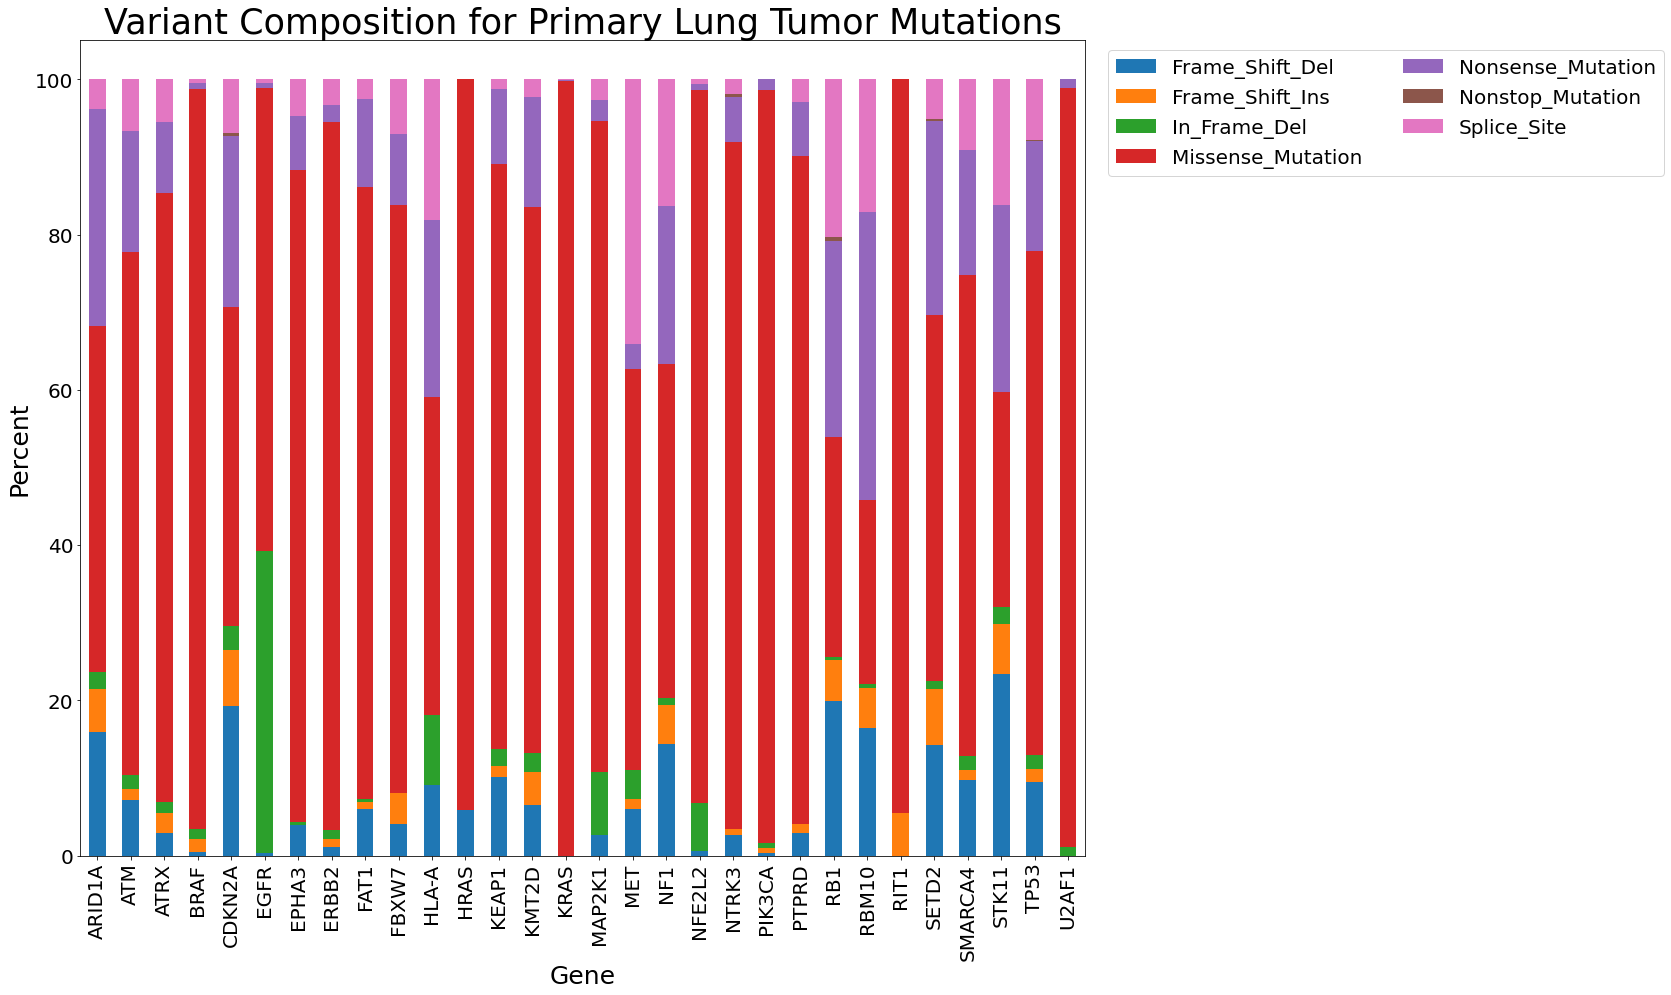

In [100]:
ax = comb_var_comp_pct_dict['prim'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Variant Composition for Primary Lung Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### Metastasis

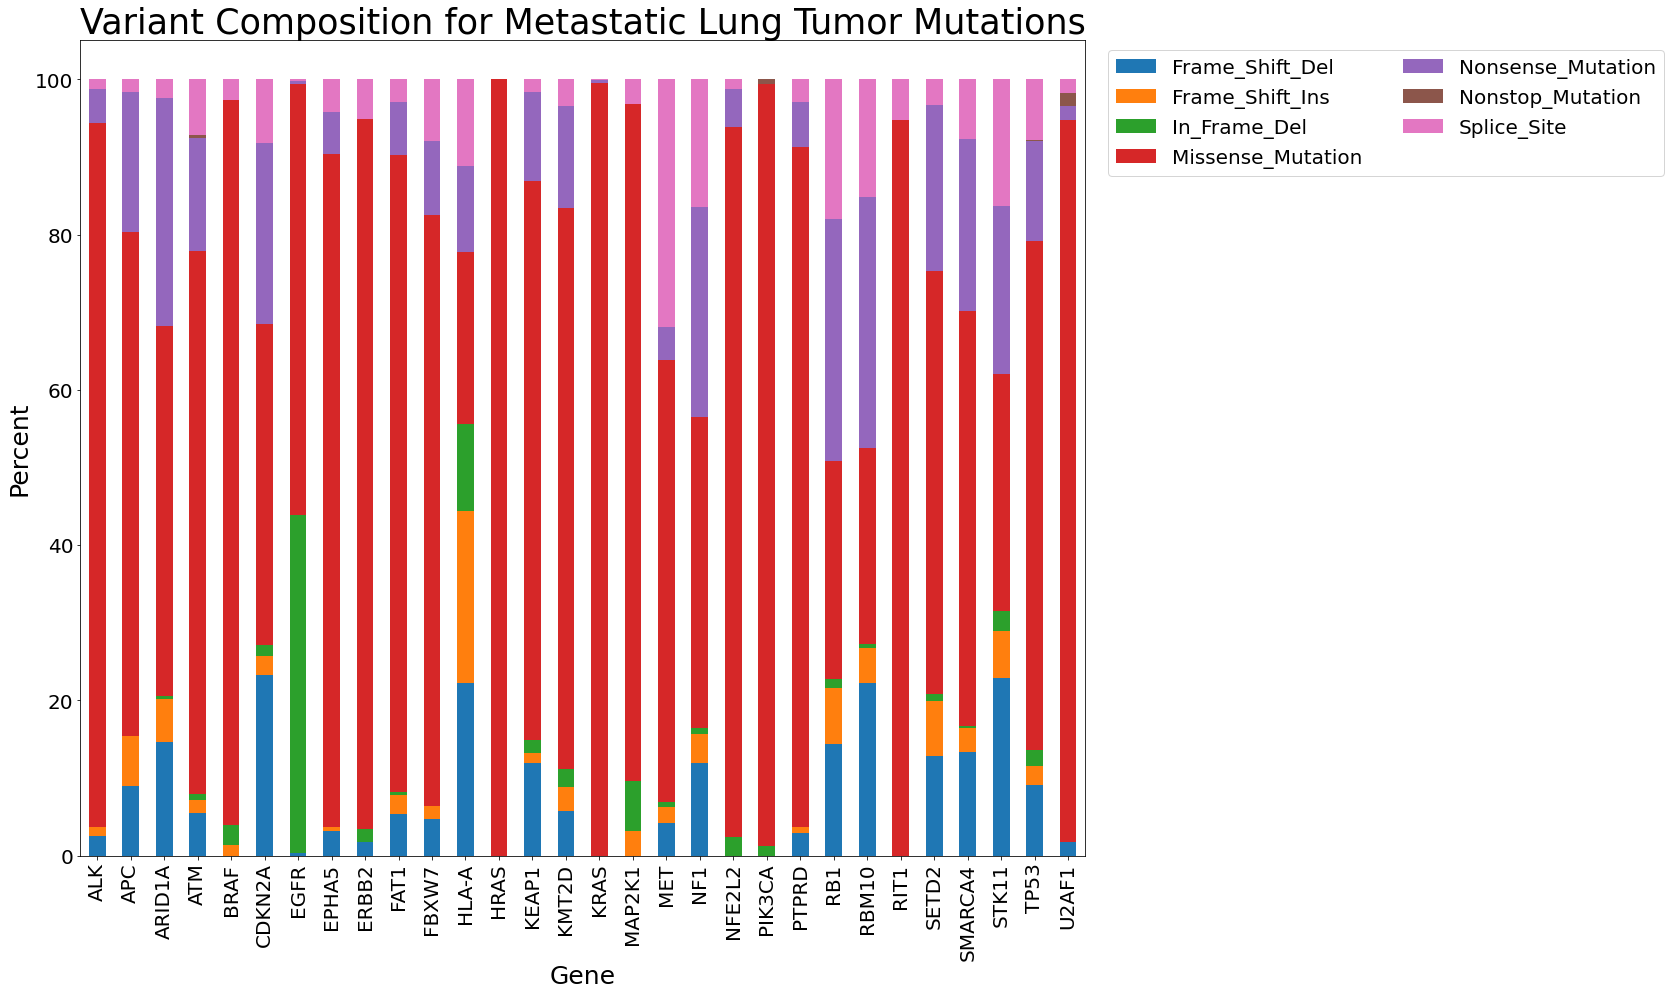

In [101]:
ax = comb_var_comp_pct_dict['met'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Variant Composition for Metastatic Lung Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Panel Composition Plots

In [102]:
comb_panel_comp_cnt_dict = {}
comb_panel_comp_pct_dict = {}

In [103]:
for (k1, v1), (k2, v2) in zip(var_mut_dict.items(), comb_mut_freq_dict.items()):
    comb_panel_comp_cnt_dict[k1], comb_panel_comp_pct_dict[k1] = panel_comp(v1, v2.index)

#### Primary

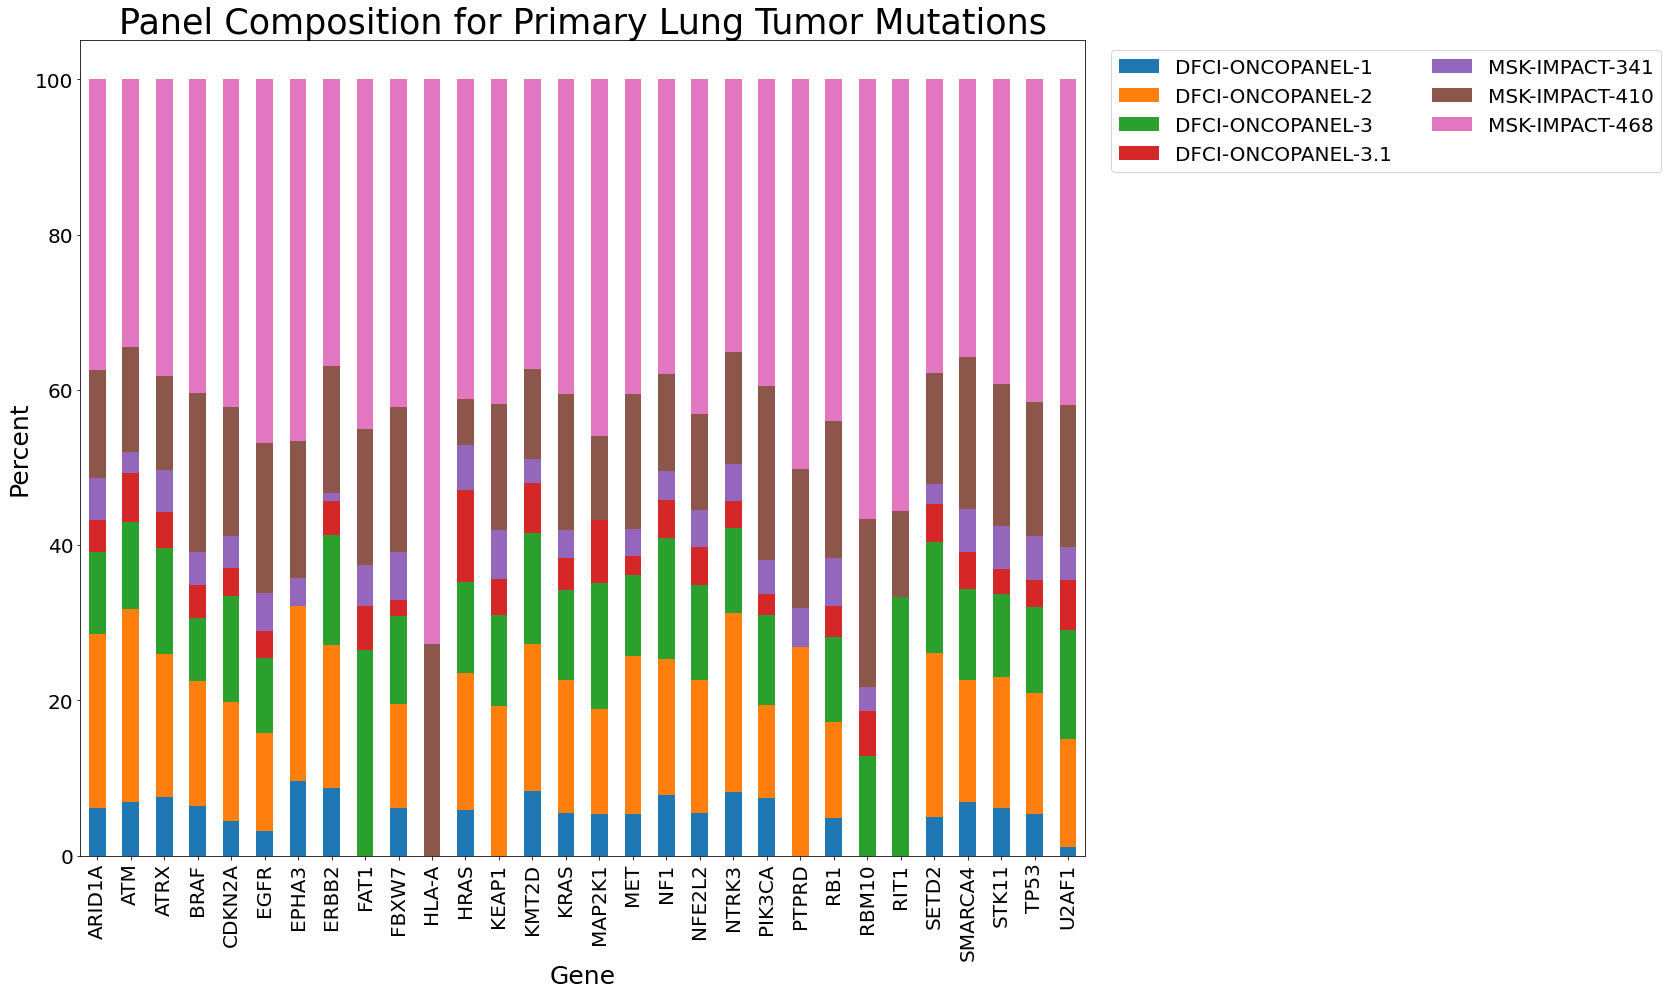

In [104]:
ax = comb_panel_comp_pct_dict['prim'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Panel Composition for Primary Lung Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

#### Metastasis

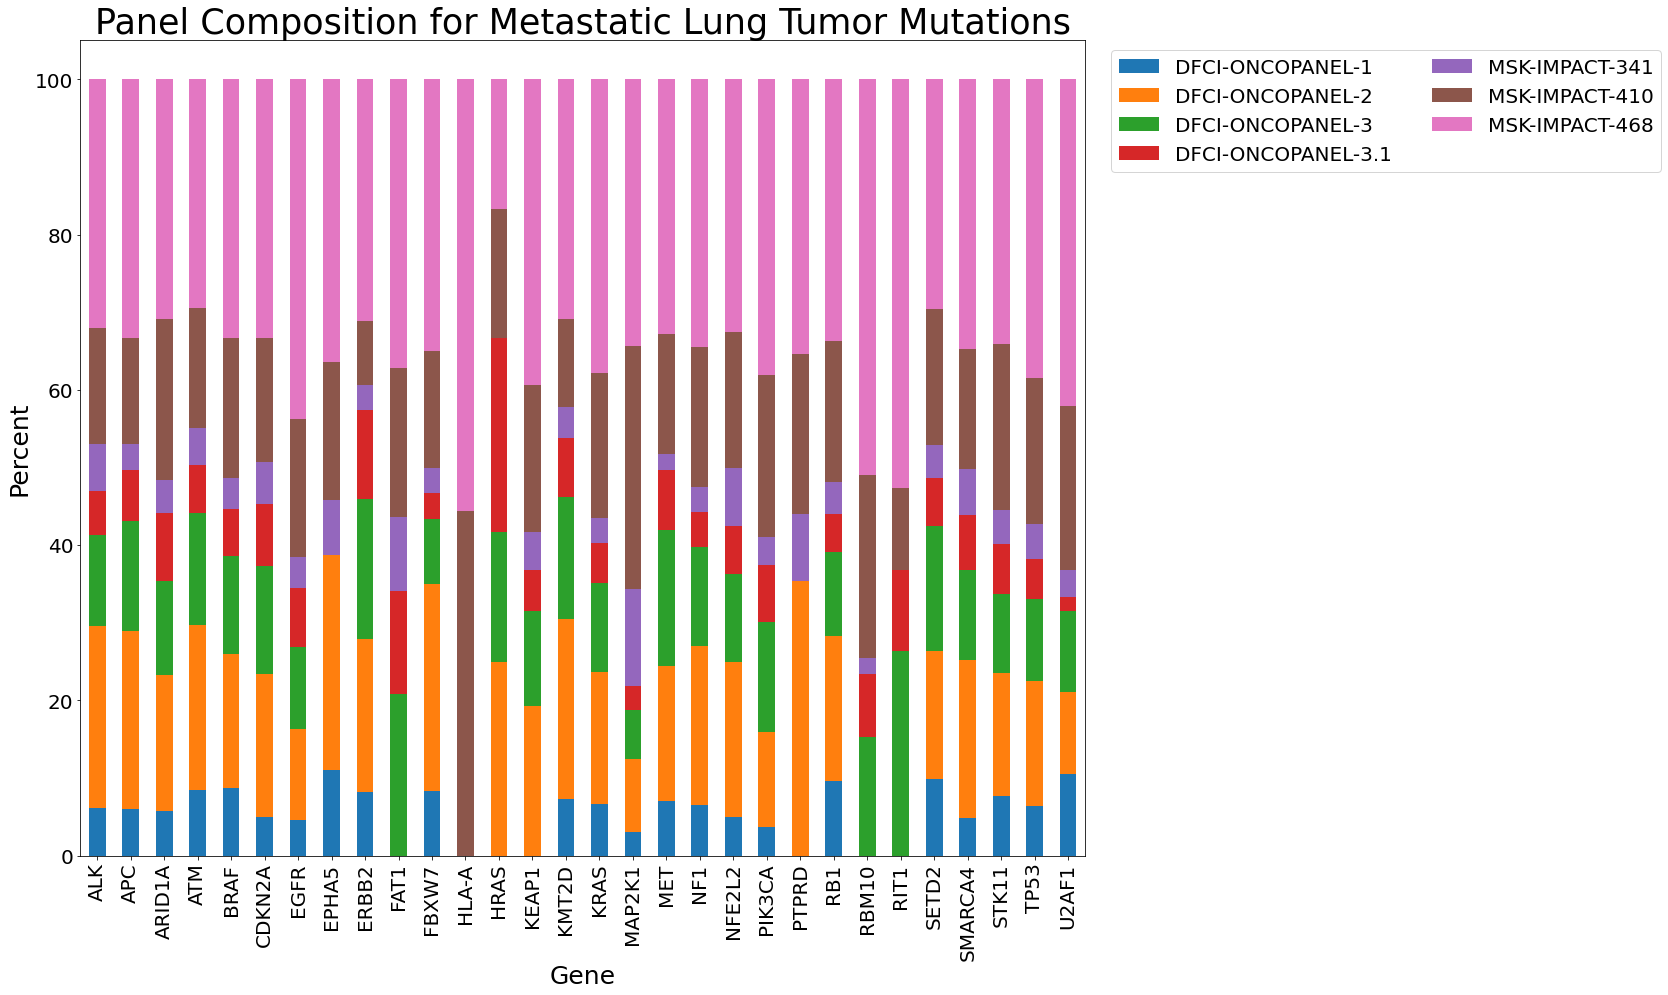

In [105]:
ax = comb_panel_comp_pct_dict['met'].plot(kind='bar', stacked=True, figsize=(30, 15))
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1), ncol=2, prop={'size':20})
plt.title("Panel Composition for Metastatic Lung Tumor Mutations", size=35)
plt.xlabel('Gene', size=25)
plt.ylabel('Percent', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

### Main Figures

In [106]:
from adjustText import adjust_text

In [107]:
x_prim = np.log10(comb_pval_dict['prim'][['Black_White_fdr', 'Black_Asian_fdr', 'Asian_White_fdr']])
x_met = -np.log10(comb_pval_dict['met'][['Black_White_fdr', 'Black_Asian_fdr', 'Asian_White_fdr']])

In [108]:
def label_outliers(x, y, labels, x_min, y_min):
    # label points that pass thresholds
    x_pass = []
    y_pass = []
    genes_pass = []
    for a, b, c in zip(x, y, labels):
        if abs(a) >= x_min and abs(b) >= y_min:
            x_pass.append(a)
            y_pass.append(b)
            genes_pass.append(c)
            
    return list(zip(x_pass, y_pass, genes_pass))

In [109]:
split_y_prim_AW = comb_pm_mut_freq_dict['prim']['Asian'] - comb_pm_mut_freq_dict['prim']['White']
split_y_prim_BW = comb_pm_mut_freq_dict['prim']['Black'] - comb_pm_mut_freq_dict['prim']['White']
split_y_prim_BA = comb_pm_mut_freq_dict['prim']['Black'] - comb_pm_mut_freq_dict['prim']['Asian']

In [110]:
split_y_met_AW = comb_pm_mut_freq_dict['met']['Asian'] - comb_pm_mut_freq_dict['met']['White']
split_y_met_BW = comb_pm_mut_freq_dict['met']['Black'] - comb_pm_mut_freq_dict['met']['White']
split_y_met_BA = comb_pm_mut_freq_dict['met']['Black'] - comb_pm_mut_freq_dict['met']['Asian']

''

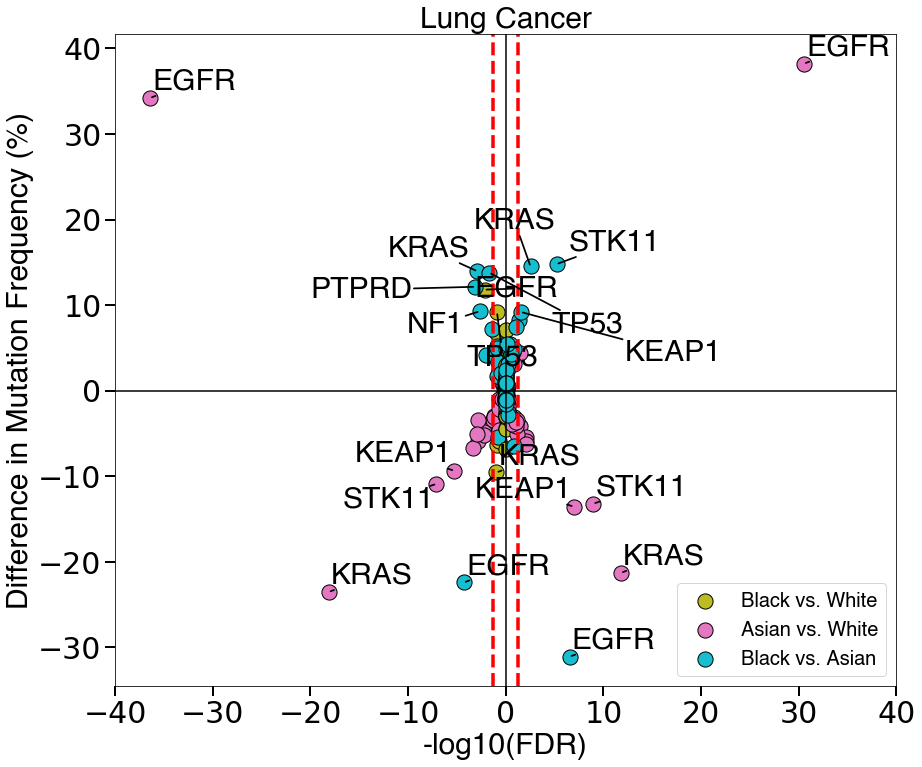

In [111]:
# Split y-axis

fig = plt.figure(figsize=(14, 12))
# fig.patch.set_facecolor('white')

plt.scatter(x_prim['Black_White_fdr'], split_y_prim_BW, label='Black vs. White', s=230, c='tab:olive', edgecolors='black')
plt.scatter(x_prim['Asian_White_fdr'], split_y_prim_AW, label='Asian vs. White', s=230, c='tab:pink', edgecolors='black')
plt.scatter(x_prim['Black_Asian_fdr'], split_y_prim_BA, label='Black vs. Asian', s=230, c='tab:cyan', edgecolors='black')

plt.scatter(x_met['Black_White_fdr'], split_y_met_BW, s=230, c='tab:olive', edgecolors='black')
plt.scatter(x_met['Asian_White_fdr'], split_y_met_AW, s=230, c='tab:pink', edgecolors='black')
plt.scatter(x_met['Black_Asian_fdr'], split_y_met_BA, s=230, c='tab:cyan', edgecolors='black')

plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

# plot significance lines
plt.axvline(x=-np.log10(0.05), c='red', linestyle='dashed', linewidth=3.5)
plt.axvline(x=np.log10(0.05), c='red', linestyle='dashed', linewidth=3.5)

hfont = {'fontname':'Helvetica'}
plt.title('Lung Cancer', size=30, **hfont)
plt.xlabel('-log10(FDR)', size=30, **hfont)
plt.ylabel('Difference in Mutation Frequency (%)', size=30, **hfont)
plt.xlim(-40, 40)
# plt.ylim(0, 20)

# plt.xticks(np.arange(-3, 3.5, 0.5))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tick_params('both', length=10, width=2, which='major')

plt.legend(
#     bbox_to_anchor=(1.05, 1), 
           loc='lower right', prop={"family":"Helvetica", 'size':20})

x = pd.concat([x_prim['Black_White_fdr'], x_prim['Asian_White_fdr'], x_prim['Black_Asian_fdr'],
          x_met['Black_White_fdr'], x_met['Asian_White_fdr'], x_met['Black_Asian_fdr']]).to_list()

y = pd.concat([split_y_prim_BW, split_y_prim_AW, split_y_prim_BA, 
               split_y_met_BW, split_y_met_AW, split_y_met_BA]).to_list()

labels = split_y_prim_BW.index.to_list() + split_y_prim_AW.index.to_list() + split_y_prim_BA.index.to_list() +\
            split_y_met_BW.index.to_list() + split_y_met_AW.index.to_list() + split_y_met_BA.index.to_list()

outliers = label_outliers(x, y, labels, 0, 9)

texts = [plt.text(x=a, y=b, s=label, size=30, **hfont) for a,b,label in outliers]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1.75))

# plt.savefig("figures/lung/lung_FDR_scatter_v2.pdf", bbox_inches='tight')
;

### Export data

In [112]:
# rearrange order of columns
pval_columns = ['Black_White_pval', 'Black_Asian_pval', 'Asian_White_pval',
                'Black_White_fdr', 'Black_Asian_fdr', 'Asian_White_fdr',
                'Black_White_odds_ratio', 'Black_Asian_odds_ratio', 'Asian_White_odds_ratio',
                'Black_White_CI', 'Black_Asian_CI', 'Asian_White_CI']

In [113]:
# # Mutation counts and sequenced counts
# comb_pm_mut_seq_dict['prim'].to_csv(
#     'data_tables/lung/lung_mut_seq_prim.txt', sep='\t')

# comb_pm_mut_seq_dict['met'].to_csv(
#     'data_tables/lung/lung_mut_seq_met.txt', sep='\t')

In [114]:
# # Mutation frequency
# comb_pm_mut_freq_dict['prim'].to_csv(
#     'data_tables/lung/lung_mut_freq_prim.txt', sep='\t')

# comb_pm_mut_freq_dict['met'].to_csv(
#     'data_tables/lung/lung_mut_freq_met.txt', sep='\t')

In [115]:
# # p-values and fdr
# comb_pval_dict['prim'][pval_columns].to_csv(
#     'data_tables/lung/lung_pval_prim.txt', sep='\t')

# comb_pval_dict['met'][pval_columns].to_csv(
#     'data_tables/lung/lung_pval_met.txt', sep='\t')

## DDR Genes

### Load DDR genes list

In [116]:
# using these genes that were sequenced by all 7 panels
DDR_genes = pd.DataFrame(['ATM', 'BRCA1', 'BRCA2', 'MSH2', 'MSH6'], columns=['Hugo_Symbol'])

In [117]:
# remove DDR genes not in dataset, if any
prim_DDR_genes = DDR_genes[DDR_genes['Hugo_Symbol'].isin(mut_seq_dict['prim'].index)]
met_DDR_genes = DDR_genes[DDR_genes['Hugo_Symbol'].isin(mut_seq_dict['met'].index)]

In [118]:
# check if number of genes changed
print(len(DDR_genes), len(prim_DDR_genes), len(met_DDR_genes))

5 5 5


In [119]:
prim_DDR_genes == met_DDR_genes

,Hugo_Symbol
0,True
1,True
2,True
3,True
4,True


In [120]:
# from here assuming prim_DDR genes are the same as met_DDR
# assuming both prim and met have the same DDR genes
# if not all True in printouts above, need to modify

In [121]:
DDR_mut_dict = {}

In [122]:
for key, value in mut_dict.items():
    DDR_mut_dict[key] = value[value['Hugo_Symbol'].isin(prim_DDR_genes.iloc[:,0])]

### Filter by variants of interest (use this for all genes calculation)

In [123]:
DDR_var_mut_dict = {}

In [124]:
for key, value in DDR_mut_dict.items():
    DDR_var_mut_dict[key] = value[value['Variant_Classification'].isin(variants)]

### Calculate mutation frequency (all genes)

In [125]:
# using all patients as common denominator
# use this mutation frequency for the combined graphs
# using variant filtered mutations
# count the number of unique patients with mutations in the DDR genes

In [126]:
DDR_all_mut_cnt_dict = {}
DDR_all_mut_freq_dict = {}

In [127]:
for (k1, v1), (k2, v2) in zip(DDR_var_mut_dict.items(), {k: race_demo_dict[k] for k in ['prim', 'met']}.items()):
    # checking order of prim and met is consistent
    print(k1, k2)
    mut_cnt = v1.groupby('PRIMARY_RACE')['PATIENT_ID'].nunique()
    mut_cnt = mut_cnt.rename('DDR Mutations')
    DDR_all_mut_cnt_dict[k1] = mut_cnt
    
    DDR_all_mut_freq_dict[k1] = (mut_cnt / v2.values * 100).to_frame().transpose()

prim prim
met met


### Fisher's Test and FDR (all genes)

In [128]:
# Note: p-values and FDR are the same here because only testing on hypothesis
# we will not adjust p-values for combined genes

In [129]:
DDR_all_pval_dict = {}

In [130]:
for (k1, v1), (k2, v2) in zip(DDR_all_mut_cnt_dict.items(), {k: race_demo_dict[k] for k in ['prim', 'met']}.items()):
    print(k1, k2)
    df = v1.append(v2).to_frame().transpose()
    df.columns = ['Asian_mut', 'Black_mut', 'White_mut', 'Asian_seq', 'Black_seq', 'White_seq']
    df.index = ['DDR Mutations']
    
    DDR_all_pval_dict[k1] = fisher_fdr_all_groups(df, groups)

prim prim
met met


In [131]:
DDR_all_pval_dict

{'prim':                Black_White_odds_ratio  Black_White_pval  Black_White_fdr  \
 DDR Mutations                0.960785          0.921522         0.921522   
 
               Black_White_CI  Black_Asian_odds_ratio  Black_Asian_pval  \
 DDR Mutations  (0.65, 1.421)                1.886978          0.018765   
 
                Black_Asian_fdr Black_Asian_CI  Asian_White_odds_ratio  \
 DDR Mutations         0.018765  (1.116, 3.19)                0.509166   
 
                Asian_White_pval  Asian_White_fdr  Asian_White_CI  
 DDR Mutations          0.000175         0.000175  (0.352, 0.737)  ,
 'met':                Black_White_odds_ratio  Black_White_pval  Black_White_fdr  \
 DDR Mutations                1.155757          0.521226         0.521226   
 
                Black_White_CI  Black_Asian_odds_ratio  Black_Asian_pval  \
 DDR Mutations  (0.771, 1.732)                     2.2          0.006087   
 
                Black_Asian_fdr  Black_Asian_CI  Asian_White_odds_ratio  \
 DDR 

In [132]:
prim_met_DDR_pval = pd.concat([DDR_all_pval_dict['prim'], DDR_all_pval_dict['met']])

In [133]:
prim_met_DDR_pval.index = ['Primary', 'Metastasis']

In [134]:
# prim_met_DDR_pval[pval_columns].to_csv('tables/lung/lung_DDR_all_pval.txt', sep='\t')

### Significant mutations (all genes)

In [135]:
DDR_all_sig_pval_dict = {}
DDR_all_sig_freq_dict = {}
DDR_all_sig_genes_dict = {}

In [136]:
for (k1, v1), (k2, v2) in zip(DDR_all_pval_dict.items(), DDR_all_mut_freq_dict.items()):
    DDR_all_sig_genes_dict[k1], DDR_all_sig_pval_dict[k1], DDR_all_sig_freq_dict[k1] = find_sig_genes_groups(groups, v1, v2, 0.05)

In [137]:
DDR_all_sig_pval_dict

{'prim': {('Black',
   'White'): Empty DataFrame
  Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
  Index: [],
  ('Black',
   'Asian'):                Black_Asian_pval  Black_Asian_fdr  Black_Asian_odds_ratio  \
  DDR Mutations          0.018765         0.018765                1.886978   
  
                Black_Asian_CI  
  DDR Mutations  (1.116, 3.19)  ,
  ('Asian',
   'White'):                Asian_White_pval  Asian_White_fdr  Asian_White_odds_ratio  \
  DDR Mutations          0.000175         0.000175                0.509166   
  
                 Asian_White_CI  
  DDR Mutations  (0.352, 0.737)  },
 'met': {('Black',
   'White'): Empty DataFrame
  Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
  Index: [],
  ('Black',
   'Asian'):                Black_Asian_pval  Black_Asian_fdr  Black_Asian_odds_ratio  \
  DDR Mutations          0.006087         0.006087                     2.2   
  
                 Bla

#### DDR Primary

In [138]:
DDR_all_sig_pval_dict['prim']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
 Index: [],
 ('Black',
  'Asian'):                Black_Asian_pval  Black_Asian_fdr  Black_Asian_odds_ratio  \
 DDR Mutations          0.018765         0.018765                1.886978   
 
               Black_Asian_CI  
 DDR Mutations  (1.116, 3.19)  ,
 ('Asian',
  'White'):                Asian_White_pval  Asian_White_fdr  Asian_White_odds_ratio  \
 DDR Mutations          0.000175         0.000175                0.509166   
 
                Asian_White_CI  
 DDR Mutations  (0.352, 0.737)  }

In [139]:
DDR_all_sig_freq_dict['prim']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black, White]
 Index: [],
 ('Black',
  'Asian'): PRIMARY_RACE       Black      Asian
 DDR Mutations  17.777778  10.280374,
 ('Asian',
  'White'): PRIMARY_RACE       Asian      White
 DDR Mutations  10.280374  18.370091}

#### Asian vs White

In [140]:
DDR_all_sig_pval_dict['prim'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
DDR Mutations,0.000175,0.000175,0.509166,"(0.352, 0.737)"


In [141]:
DDR_all_sig_pval_dict['prim'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
DDR Mutations,0.000175,0.000175,0.509166,"(0.352, 0.737)"


#### Black vs White

In [142]:
DDR_all_sig_pval_dict['prim'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


In [143]:
DDR_all_sig_pval_dict['prim'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


#### Black vs Asian

In [144]:
DDR_all_sig_pval_dict['prim'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
DDR Mutations,0.018765,0.018765,1.886978,"(1.116, 3.19)"


In [145]:
DDR_all_sig_pval_dict['prim'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
DDR Mutations,0.018765,0.018765,1.886978,"(1.116, 3.19)"


#### DDR Metastasis

In [146]:
DDR_all_sig_pval_dict['met']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black_White_pval, Black_White_fdr, Black_White_odds_ratio, Black_White_CI]
 Index: [],
 ('Black',
  'Asian'):                Black_Asian_pval  Black_Asian_fdr  Black_Asian_odds_ratio  \
 DDR Mutations          0.006087         0.006087                     2.2   
 
                Black_Asian_CI  
 DDR Mutations  (1.272, 3.806)  ,
 ('Asian',
  'White'):                Asian_White_pval  Asian_White_fdr  Asian_White_odds_ratio  \
 DDR Mutations          0.000968         0.000968                0.525344   
 
                Asian_White_CI  
 DDR Mutations  (0.354, 0.781)  }

In [147]:
DDR_all_sig_freq_dict['met']

{('Black',
  'White'): Empty DataFrame
 Columns: [Black, White]
 Index: [],
 ('Black',
  'Asian'): PRIMARY_RACE       Black      Asian
 DDR Mutations  24.264706  12.711864,
 ('Asian',
  'White'): PRIMARY_RACE       Asian      White
 DDR Mutations  12.711864  21.704394}

#### Asian vs White

In [148]:
DDR_all_sig_pval_dict['met'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
DDR Mutations,0.000968,0.000968,0.525344,"(0.354, 0.781)"


In [149]:
DDR_all_sig_pval_dict['met'][('Asian', 'White')]

,Asian_White_pval,Asian_White_fdr,Asian_White_odds_ratio,Asian_White_CI
DDR Mutations,0.000968,0.000968,0.525344,"(0.354, 0.781)"


#### Black vs White

In [150]:
DDR_all_sig_pval_dict['met'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


In [151]:
DDR_all_sig_pval_dict['met'][('Black', 'White')]

,Black_White_pval,Black_White_fdr,Black_White_odds_ratio,Black_White_CI


#### Black vs Asian

In [152]:
DDR_all_sig_pval_dict['met'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
DDR Mutations,0.006087,0.006087,2.2,"(1.272, 3.806)"


In [153]:
DDR_all_sig_pval_dict['met'][('Black', 'Asian')]

,Black_Asian_pval,Black_Asian_fdr,Black_Asian_odds_ratio,Black_Asian_CI
DDR Mutations,0.006087,0.006087,2.2,"(1.272, 3.806)"


### Mutation frequency plots (all genes)

In [154]:
prim_met_DDR = pd.concat([DDR_all_mut_freq_dict['prim'], DDR_all_mut_freq_dict['met']])

In [155]:
prim_met_DDR.index = ['Primary', 'Metastasis']

In [156]:
# prim_met_DDR.to_csv('tables/lung/DDR_all_mut_freq.txt', sep='\t')

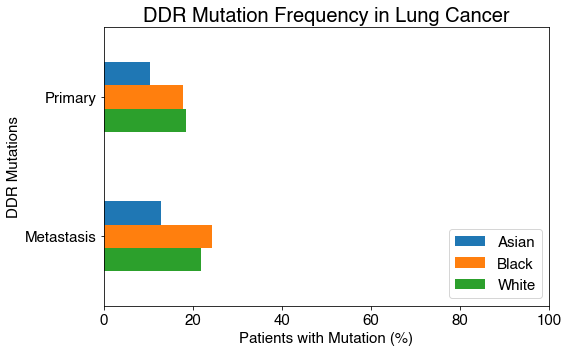

In [157]:
ax = (prim_met_DDR).plot(kind='barh', figsize=(8, 5), width=0.5)
hfont = {'fontname':'Helvetica'}
plt.title('DDR Mutation Frequency in Lung Cancer', fontsize=20, **hfont)
plt.xlabel('Patients with Mutation (%)', fontsize=15, **hfont)
plt.ylabel('DDR Mutations', fontsize=15, **hfont)
plt.xticks(size=15, **hfont)
plt.yticks(size=15, **hfont)
plt.xlim((0, 100))
ax.invert_yaxis()
ax.set_yticklabels(['Primary', 'Metastasis'])
plt.legend(prop={'family': 'Helvetica', 'size': 15}, loc='lower right')
plt.tight_layout()
# plt.savefig('figures/Lung/DDR_Actionable/lung_DDR_Action_all_prim.pdf')

# Total mutation counts

## Count mutations in each patient

In [158]:
# find genes that were sequenced by all panels, using this as our driver gene list
common_genes = combined_panels[combined_panels['SEQ_ASSAY_ID'].apply(len) == 7].index

In [159]:
len(common_genes)

181

In [160]:
# Count number of mutations (specified by list) in each patient, separated by primary/metstastasis and by race

# removing duplicates:
# first choose sample sequenced by later panel
# then if still duplicates, choose the sample with the largest mutation count

# mut_tbl: mutation table in MAF format
# driver_genes: list of driver genes to be counted
# races: list of races to separate by
def count_mutations(mut_tbl, genes, races):
    race_dict = {}
    mut = mut_tbl[mut_tbl['Hugo_Symbol'].isin(genes)]
    # remove assay duplicates
    mut = remove_duplicates(mut)
    
    for race in races:
        # these are patients with >= 1 count
        race_mut = mut[mut['PRIMARY_RACE'] == race]
        race_mut_cnt = race_mut.groupby(['PATIENT_ID', 'SAMPLE_ID'])['SAMPLE_ID'].count()
        
        # for remaining duplicates, choose sample with highest mutation count
        race_mut_cnt = race_mut_cnt.groupby('PATIENT_ID').max()
        
        # find patients with zero counts and add them back in
        zero_IDs = mut_tbl[(mut_tbl['PRIMARY_RACE'] == race) & 
                           ~(mut_tbl['PATIENT_ID'].isin(race_mut_cnt.index))]['PATIENT_ID'].unique()
        zero_mut_cnt = pd.Series(index=zero_IDs, data=0)
        
        total_cnt = pd.concat([race_mut_cnt, zero_mut_cnt], axis=0)
        total_cnt = total_cnt.rename('Mutation Count')

        race_dict[race] = total_cnt
    
    return race_dict

In [161]:
driver_dict = {}

In [162]:
for key, value in var_mut_dict.items():
    driver_dict[key] = count_mutations(value, common_genes, races)

## Mean and Median

In [163]:
median_dict = {}

In [164]:
for key, value in driver_dict.items():
    means = []
    medians = []
    for race in races:
        medians.append(np.median(value[race]))
        means.append(np.mean(value[race]))
    df = pd.DataFrame(np.array([means, medians]), index=['Mean', 'Median'], columns=races)
    median_dict[key] = df

In [165]:
median_dict['prim']

,Asian,Black,White
Mean,3.768987,5.494444,5.178204
Median,3.000000,4.000000,4.000000


In [166]:
median_dict['met']

,Asian,Black,White
Mean,4.394068,5.536765,5.785937
Median,4.000000,4.000000,5.000000


In [167]:
# median_dict['prim'].to_csv('tables/lung/lung_prim_median_count.txt', sep='\t')

In [168]:
# median_dict['met'].to_csv('tables/lung/lung_met_median_count.txt', sep='\t')

## Calculate significance (Wilcoxon Rank Sum)

In [169]:
# calculate if distribution of mutation counts is different between races, including outliers
# using Wilcoxon because mutation counts of each race is not normally distributed (tested using shapiro-wilk test)
# also calculate percent difference of median count between races

In [170]:
driver_pval_dict = {}

In [171]:
# calculates the confidence interval of difference of medians for wilcoxon rank sum test
# taken from here: https://gist.github.com/meetbash/aa5dbbeae746a173c5421ac57b45fe70#file-non_param_paired_ci-py

def non_param_unpaired_CI(sample1, sample2, conf):
    n1 = len(sample1)  
    n2 = len(sample2)  
    alpha = 1-conf      
    N = stats.norm.ppf(1 - alpha/2) 
    # The confidence interval for the difference between the two population
    # medians is derived through the n x m differences.
    diffs = sorted([i-j for i in sample1 for j in sample2])
    # the Kth smallest to the Kth largest of the n x m differences then determine 
    # the confidence interval, where K is:
    k = np.math.ceil(n1*n2/2 - (N * (n1*n2*(n1+n2+1)/12)**0.5))
    CI = (round(diffs[k-1],3), round(diffs[len(diffs)-k],3))
    return CI

In [172]:
for key, value in driver_dict.items():
    df = pd.DataFrame(index=['Rank Sum Stat', 'p-value', 'CI', 'Mean Percent Difference'])
    for group in groups:
        pct_diff = (np.mean(value[group[0]]) - np.mean(value[group[1]])) / np.mean(value[group[1]]) * 100
        CI = non_param_unpaired_CI(value[group[0]], value[group[1]], 0.95)
        df[group[0] + '_' + group[1]] = list(stats.ranksums(value[group[0]], value[group[1]])) + [CI] + [pct_diff]
    driver_pval_dict[key] = df

In [173]:
print('Primary Stats:')
driver_pval_dict['prim']

Primary Stats:


,Black_White,Black_Asian,Asian_White
Rank Sum Stat,-0.0629917,4.41931,-7.5015
p-value,0.949773,9.90166e-06,6.30894e-14
CI,"(0, 0)","(1, 2)","(-1, -1)"
Mean Percent Difference,6.10714,45.7804,-27.2144


In [174]:
print('Metastatic Stats:')
driver_pval_dict['met']

Metastatic Stats:


,Black_White,Black_Asian,Asian_White
Rank Sum Stat,-0.837427,2.68065,-5.56049
p-value,0.402353,0.00734792,2.69022e-08
CI,"(-1, 0)","(0, 1)","(-1, -1)"
Mean Percent Difference,-4.30651,26.0054,-24.0561


In [175]:
# driver_pval_dict['prim'].to_csv('tables/lung/lung_prim_count_stats.txt', sep='\t')

In [176]:
# driver_pval_dict['met'].to_csv('tables/lung/lung_met_count_stats.txt', sep='\t')

## Box Plot

In [177]:
driver_count_dict = {}

In [178]:
for key, value in driver_dict.items():
    dfs = []
    for race in races:
        df = pd.DataFrame(value[race])
        df['Race'] = race
        if key == 'prim':
            df['Sample Type'] = 'Primary'
        else:
            df['Sample Type'] = 'Metastasis'
        dfs.append(df)
    driver_count_dict[key] = pd.concat(dfs)   

In [179]:
driver_df = pd.concat([driver_count_dict['prim'], driver_count_dict['met']])

### Try a log scale

In [180]:
# adding 1 to prevent infinity values
driver_df['log10(Mutation Count)'] = np.log10(driver_df['Mutation Count'] + 1)

''

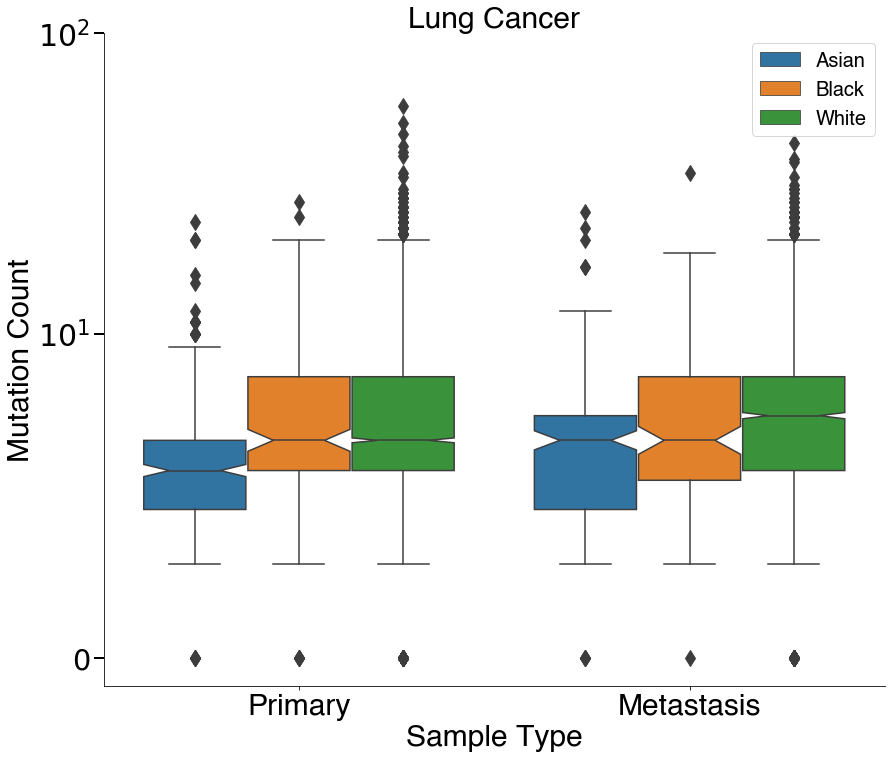

In [181]:
plt.figure(figsize=(14, 12))
ax = sns.boxplot(data=driver_df[['log10(Mutation Count)', 'Race', 'Sample Type']], 
                 hue='Race', x='Sample Type', y='log10(Mutation Count)', notch=True, fliersize=12,
#                 width=
                )
# plt.ylim(-0.1, 3)
# ax.set_xlim(-0.55, 1.55)
sns.despine(ax=ax)

hfont = {'fontname':'Helvetica'}
plt.title('Lung Cancer', size=30, **hfont)
plt.xlabel('Sample Type', size=30, **hfont)
plt.ylabel('Mutation Count', size=30, **hfont)
plt.xticks(fontsize=30, **hfont)
ax.set_yticks([np.log10(1), np.log10(11), np.log10(101)])
ax.set_yticklabels(['0', '$10^1$', '$10^2$'])
plt.yticks(fontsize=30, **hfont)
plt.tick_params('y', length=10, width=2, which='major')


plt.legend(loc='upper right', prop={"family":"Helvetica", 'size':20})
# plt.savefig("figures/lung/lung_boxplot_v3.pdf", bbox_inches='tight')
;

In [182]:
# Try removing patients with EGFR mutations to see if that affects the distribution

In [183]:
'EGFR' in common_genes

True

In [184]:
no_EGFR_dict = {}

In [185]:
no_EGFR_mut_dict = {}

In [186]:
for key, value in var_mut_dict.items():
    EGFR_IDs = value[value['Hugo_Symbol'] == 'EGFR']['PATIENT_ID'].unique()
    no_EGFR_mut_dict[key] = value[~value['PATIENT_ID'].isin(EGFR_IDs)]

In [187]:
for key, value in no_EGFR_mut_dict.items():
    no_EGFR_dict[key] = count_mutations(value, common_genes[~common_genes.isin(['EGFR'])], races)

In [188]:
no_EGFR_median_dict = {}

In [189]:
for key, value in no_EGFR_dict.items():
    means = []
    medians = []
    for race in races:
        medians.append(np.median(value[race]))
        means.append(np.mean(value[race]))
    df = pd.DataFrame(np.array([means, medians]), index=['Mean', 'Median'], columns=races)
    no_EGFR_median_dict[key] = df

In [190]:
no_EGFR_median_dict['prim']

,Asian,Black,White
Mean,4.068493,5.544,5.31988
Median,3.000000,4.000,4.00000


In [191]:
no_EGFR_median_dict['met']

,Asian,Black,White
Mean,4.43617,5.773196,5.992622
Median,3.00000,5.000000,5.000000


In [192]:
no_EGFR_pval_dict = {}

In [193]:
for key, value in no_EGFR_dict.items():
    df = pd.DataFrame(index=['Rank Sum Stat', 'p-value', 'Mean Percent Difference'])
    for group in groups:
        pct_diff = (np.mean(value[group[0]]) - np.mean(value[group[1]])) / np.mean(value[group[1]]) * 100
        df[group[0] + '_' + group[1]] = list(stats.ranksums(value[group[0]], value[group[1]])) + [pct_diff]
    no_EGFR_pval_dict[key] = df

In [194]:
# still see significant differences after removing patients with EGFR mutations from the counts
# but less significant as before

In [195]:
no_EGFR_pval_dict['prim']

,Black_White,Black_Asian,Asian_White
Rank Sum Stat,-0.492141,2.828183,-4.920800e+00
p-value,0.622619,0.004681,8.619098e-07
Mean Percent Difference,4.212879,36.266667,-2.352284e+01


In [196]:
no_EGFR_pval_dict['met']

,Black_White,Black_Asian,Asian_White
Rank Sum Stat,-0.651835,2.406056,-4.090307
p-value,0.514507,0.016126,0.000043
Mean Percent Difference,-3.661605,30.139188,-25.972801
